In [1]:
import sys
import os
sys.path.append('..')
import numpy as np
import pandas as pd
from models import sir
from config import get_project_root
import torchmetrics
from models.pytorchtools import EarlyStopping

In [2]:
enfermedad='sarampion'
DATA_FOLDER = f'{get_project_root()}/data'
INFECTADOS_PATH = f'{DATA_FOLDER}/extrapolated/infectados_{enfermedad}_extrapolado.csv'
HABITANTES_PATH = f'{DATA_FOLDER}/extrapolated/habitantes_{enfermedad}_extrapolado.csv'
VACUNADOS_PATH = f'{DATA_FOLDER}/extrapolated/vacunados_{enfermedad}_extrapolado.csv'
YEARS = [2018, 2019, 2020, 2021, 2022]
MONTHS = ['ENE', 'FEB', 'MAR', 'ABR', 'MAY', 'JUN', 'JUL', 'AGOS', 'SEP', 'OCT', 'NOV', 'DIC']


In [3]:
habitantes_curve = pd.read_csv(HABITANTES_PATH).set_index('ANO')
for month in MONTHS:
    habitantes_curve[month] = habitantes_curve['JUL']
max_habs = habitantes_curve.max().max()
max_habs

11101945

In [4]:
def extract_curve(path=None, df=None):
    if df is None:
        df = pd.read_csv(path).set_index('ANO')
    df = df[df.columns[:12]].T
    values = []
    for year in YEARS:
        values.extend(df[year].tolist())
    return pd.Series(values)

infectuous_curve = extract_curve(path=INFECTADOS_PATH)  
vacunados_curve = extract_curve(path=VACUNADOS_PATH)
recovered_curve = pd.Series([0]*len(infectuous_curve))
max_habs = max([habitantes_curve.max().max(), vacunados_curve.max().max()])

In [5]:
habitantes_curve

,ENE,FEB,MAR,ABR,MAY,JUN,JUL,AGOS,SEP,OCT,NOV,DIC
ANO,,,,,,,,,,,,
2018,10973470,10973470,10973470,10973470,10973470,10973470,10973470,10973470,10973470,10973470,10973470,10973470
2019,11012606,11012606,11012606,11012606,11012606,11012606,11012606,11012606,11012606,11012606,11012606,11012606
2020,11047665,11047665,11047665,11047665,11047665,11047665,11047665,11047665,11047665,11047665,11047665,11047665
2021,11077856,11077856,11077856,11077856,11077856,11077856,11077856,11077856,11077856,11077856,11077856,11077856
2022,11101945,11101945,11101945,11101945,11101945,11101945,11101945,11101945,11101945,11101945,11101945,11101945


In [6]:
for ix, val in enumerate(infectuous_curve):
    try:
        recovered_curve[ix+1] += val
    except KeyError:
        continue

In [7]:
max_habs

14172606.0

In [8]:
susceptible_curve = max_habs - infectuous_curve - vacunados_curve - recovered_curve
susceptible_curve[susceptible_curve<0] = 0



In [9]:
data = pd.concat([susceptible_curve, infectuous_curve, recovered_curve, vacunados_curve], axis=1).rename(columns={0:'Susceptible', 1:'Infectados', 2:'Recuperados', 3:'Vacunados'})
infectados_real = data.diff()['Infectados']
infectados_real.loc[0] = 0
infectados_real
data['Infectados'] = infectados_real

In [10]:
data

,Susceptible,Infectados,Recuperados,Vacunados
0,3151427.0,0.0,0,11021179.0
1,2893840.0,0.0,0,11278766.0
2,2115966.0,0.0,0,12056640.0
3,2063790.0,0.0,0,12108816.0
4,1997836.0,12.0,0,12174758.0
5,1952716.0,0.0,12,12219866.0
6,1908172.0,0.0,12,12264410.0
7,1849594.0,4.0,12,12322984.0
8,1773034.0,1.0,16,12399539.0
9,1703849.0,2.0,17,12468721.0


In [11]:
data_numpy = np.array(data)/max_habs

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [13]:
class SIRV(nn.Module):
    def __init__(self, epsilon=1e-7):
        super(SIRV, self).__init__()
        self.lambda1 = nn.Linear(1,1, bias = False) # tasa de contacto efectivo
        self.lambda2 = nn.Linear(1,1, bias = False) # tasa de immunizacion
        self.lambda3 = nn.Linear(1,1, bias = False) # tasa de recuperacion
        torch.nn.init.xavier_uniform_(self.lambda1.weight, gain=0.01)
        torch.nn.init.xavier_uniform_(self.lambda2.weight, gain=0.01)
        torch.nn.init.xavier_uniform_(self.lambda3.weight, gain=0.01)
        self.epsilon = epsilon
    
    def forward(self, x, size_of_starter_set, amount_of_prediction_in_future):
        assert size_of_starter_set < amount_of_prediction_in_future
        ns = torch.zeros([amount_of_prediction_in_future, 4],dtype=torch.float, requires_grad = False)
        torch.nn.init.xavier_uniform_(ns, gain=0.01)
        x[x==0] = self.epsilon
        ns[:x.shape[0]] = x.view(x.shape[0], 4).clone()
        for i in range(size_of_starter_set,amount_of_prediction_in_future):
            a = ns[i-1].clone()
            ns[i][0] = a[0].view(1,1) - self.lambda1(a[0]*a[1].view(1,1)) - self.lambda2(a[0].view(1,1))
            ns[i][1] = a[1].view(1,1) + self.lambda1(a[0]*a[1].view(1,1)) - self.lambda3(a[1].view(1,1))  - self.lambda2(a[1].view(1,1))
            ns[i][2] = a[2].view(1,1) + self.lambda3(a[1].view(1,1))
            ns[i][3] = a[3].view(1,1) + self.lambda2(a[0].view(1,1)) + self.lambda2(a[1].view(1,1)) 
        return ns[1:].reshape(-1,4)


In [14]:
def loss_custom(pred, actual):
    loss_func = nn.SmoothL1Loss()
    loss_big = loss_func(pred[:,3], actual[:,3]) + loss_func(pred[:,0], actual[:,0])
    loss_small = loss_func(pred[:,1], actual[:,1]) + loss_func(pred[:,2], actual[:,2])
    return 1000*loss_small + loss_big

In [15]:
y = torch.from_numpy(data_numpy.astype(np.float32))


In [16]:
y.size()

torch.Size([60, 4])

In [17]:
import os
model_checkpoint_folder = f'models/{enfermedad}/checkpoints'
trained_models_foder = 'models/trained_models'
os.makedirs(model_checkpoint_folder, exist_ok=True)
os.makedirs(trained_models_foder, exist_ok=True)

In [18]:
def train(train_set, fold_size=10, future_size=5):
    epsilon = 1e-15
    sir = SIRV(epsilon=epsilon)
    opt = torch.optim.Adam(sir.parameters(), lr=0.05)
    best = 10000
    early_stopping = EarlyStopping(patience=25, verbose=False, delta=1e-7)
    for epoch in range(500):
        out = sir(train_set[:fold_size], size_of_starter_set=min(10, fold_size), amount_of_prediction_in_future=fold_size + future_size+1)
        out = out.squeeze()
        loss = loss_custom(out, train_set[:fold_size + future_size])
        loss.backward()
        opt.step() 
        opt.zero_grad()
        if loss.item() < best:
            best = loss.item()
            torch.save(sir, f'{model_checkpoint_folder}/{enfermedad}_{fold_size}.pkl')
        if epoch%25 == 0:        
            print(f'Epoch: {epoch}, loss: {loss.item()}')
        if loss.isnan():
            raise ValueError()
        for p in sir.parameters():
            p.data.clamp_(0)
        early_stopping(loss.item(), sir)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    return best
    

def train_and_val_k_fold():
    divergences = {}
    rmses = []
    losses = {}
    future_index_check = 10
    min_datapoints = 25
    for fold_size in range(min_datapoints, len(y)-future_index_check):
        print(f'\nAnalyzing fold: {fold_size}\n')
        folded_train_set = y[:fold_size+future_index_check+1].clone()
        best_loss = train(train_set=folded_train_set, fold_size=fold_size, future_size=future_index_check)
        model = torch.load(f'{model_checkpoint_folder}/{enfermedad}_{fold_size}.pkl')
        preds = model(folded_train_set[:fold_size], size_of_starter_set=fold_size, amount_of_prediction_in_future=len(folded_train_set)+1)[fold_size:fold_size+future_index_check]
        target = y[fold_size:fold_size+future_index_check]
        target[target==0] = 1e-15
        kl_divergence = torch.nn.functional.kl_div(target.log(), preds, reduction='batchmean').detach().item()
        rmse = torch.sqrt(torchmetrics.functional.mean_squared_error(target, preds)).detach().item()
        print(f'\nKL Divergence:{kl_divergence}\n')
        print(f'\nRMSE:{rmse}\n')
        divergences[fold_size] = kl_divergence
        rmses.append(rmse)
        losses[fold_size] = best_loss
    return divergences, rmses, losses

In [19]:
divergences, rmses, losses = train_and_val_k_fold()


Analyzing fold: 25

Epoch: 0, loss: 0.0014141108840703964
Epoch: 25, loss: 0.00013064162340015173
Epoch: 50, loss: 0.00013179694360587746
EarlyStopping reached!
Early stopping

KL Divergence:0.0010539686772972345


RMSE:0.0065793502144515514


Analyzing fold: 26

Epoch: 0, loss: 0.0026021215599030256
Epoch: 25, loss: 0.00021863722940906882
Epoch: 50, loss: 0.0001526441192254424
EarlyStopping reached!
Early stopping

KL Divergence:0.0010758598800748587


RMSE:0.006631946191191673


Analyzing fold: 27

Epoch: 0, loss: 0.001256329589523375
Epoch: 25, loss: 0.00018197298049926758
EarlyStopping reached!
Early stopping

KL Divergence:0.0014338369946926832


RMSE:0.007597188465297222


Analyzing fold: 28

Epoch: 0, loss: 0.004907477181404829
Epoch: 25, loss: 0.0009297652286477387
EarlyStopping reached!
Early stopping

KL Divergence:0.0039564575999975204


RMSE:0.012199435383081436


Analyzing fold: 29

Epoch: 0, loss: 0.0014158965786918998
Epoch: 25, loss: 0.0001384749193675816
Epoch: 50, lo

In [20]:
print(f'Cross-validated KL Divergence: {pd.Series(divergences.values()).mean()}')
print(f'Cross-validated RMSE: {pd.Series(rmses).mean()}')

Cross-validated KL Divergence: 0.03889174020383507
Cross-validated RMSE: 0.007724242378026247


In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

best_fold_size = min(losses, key=losses.get)
model = torch.load(f'{model_checkpoint_folder}/{enfermedad}_{best_fold_size}.pkl')
torch.save(model, f'models/trained_models/{enfermedad}.pkl')

y = torch.from_numpy(data_numpy.astype(np.float32))
res = model(y, size_of_starter_set=best_fold_size, amount_of_prediction_in_future=len(y))


In [23]:
import pathlib
for i in range(len(y)):
    file_to_rem = pathlib.Path(f'{model_checkpoint_folder}/{enfermedad}_{i}.pkl')
    if os.path.isfile(file_to_rem):
        file_to_rem.unlink()
file_to_rem = pathlib.Path(f'checkpoint.pt')
file_to_rem.unlink()

In [24]:
import os
os.makedirs(f'figures/{enfermedad}', exist_ok=True)

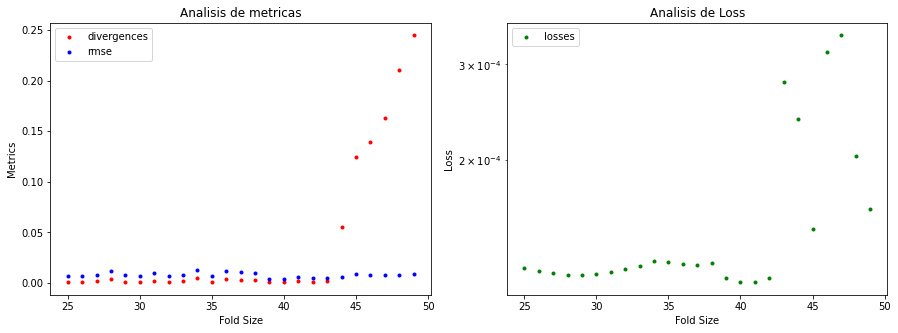

In [25]:
fold_sizes = losses.keys()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax[0].plot(fold_sizes, divergences.values(), color = 'r', linewidth=0, marker='.', label='divergences')
ax[0].plot(fold_sizes, rmses, color = 'b', linewidth=0, marker='.', label='rmse')
ax[1].set_yscale('log')
ax[0].set_ylabel('Metrics')
ax[0].set_xlabel('Fold Size')
ax[0].set_title('Analisis de metricas')
ax[0].legend()


ax[1].plot(fold_sizes, losses.values(), color = 'g', linewidth=0, marker='.', label='losses')
ax[1].set_ylabel('Loss')
ax[1].set_yscale('log')
ax[1].set_xlabel('Fold Size')
ax[1].set_title('Analisis de Loss')
ax[1].legend()

plt.show()

/var/folders/g0/jqvp4xxs5pn4cds1xb9339xm0000gn/T/ipykernel_5213/700671155.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "linewidth" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'figures/{enfermedad}/accumul_prediction.png', format='png', linewidth = 0.01)


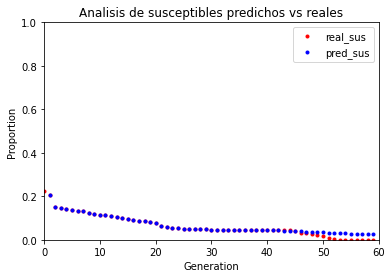

In [26]:
predicted_susceptible = res[:,0].detach().numpy()
real_susceptible = y[:,0].detach().numpy()
plt.plot(data.index, real_susceptible, color = 'r', linewidth=0, marker='.', label='real_sus')
plt.plot(data.index[1:], predicted_susceptible, color = 'b', linewidth=0, marker='.', label='pred_sus')
plt.ylim(0, 1)
plt.xlim(0,len(y))
plt.ylabel('Proportion')
plt.xlabel('Generation')
plt.title('Analisis de susceptibles predichos vs reales')
plt.legend()
plt.savefig(f'figures/{enfermedad}/accumul_prediction.png', format='png', linewidth = 0.01)

/var/folders/g0/jqvp4xxs5pn4cds1xb9339xm0000gn/T/ipykernel_5213/2298925115.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "linewidth" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'figures/{enfermedad}/accumul_prediction_vaccinated.png', format='png', linewidth = 0.01)


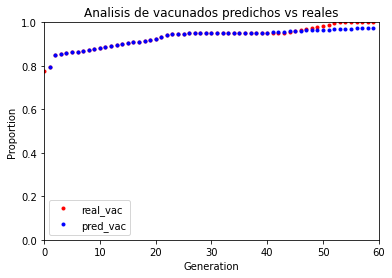

In [27]:
predicted_vaccinated = res[:,3].detach().numpy()
real_vaccinated = y[:,3].detach().numpy()
plt.plot(data.index, real_vaccinated, color = 'r', linewidth=0, marker='.', label='real_vac')
plt.plot(data.index[1:], predicted_vaccinated, color = 'b', linewidth=0, marker='.', label='pred_vac')
plt.ylim(0, 1)
plt.xlim(0,len(y))
plt.ylabel('Proportion')
plt.xlabel('Generation')
plt.title('Analisis de vacunados predichos vs reales')
plt.legend()
plt.savefig(f'figures/{enfermedad}/accumul_prediction_vaccinated.png', format='png', linewidth = 0.01)

Que pasa si le damos mas peso a fitear a los susceptibles?


/var/folders/g0/jqvp4xxs5pn4cds1xb9339xm0000gn/T/ipykernel_5213/652839925.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "linewidth" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'figures/{enfermedad}/accumul_infected.png', format='png', linewidth = 0.01)


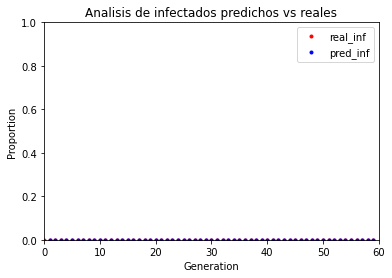

In [28]:
predicted_infected = res[:,1].detach().numpy()
real_infected = y[:,1].detach().numpy()
plt.plot(data.index, real_infected, color = 'r', linewidth=0, marker='.', label='real_inf')
plt.plot(data.index[1:], predicted_infected, color = 'b', linewidth=0, marker='.', label='pred_inf')
# plt.yscale('log')
plt.xlim(0,len(y))
plt.ylim(0,1)
plt.ylabel('Proportion')
plt.xlabel('Generation')
plt.title('Analisis de infectados predichos vs reales')
plt.legend()
plt.savefig(f'figures/{enfermedad}/accumul_infected.png', format='png', linewidth = 0.01)

/var/folders/g0/jqvp4xxs5pn4cds1xb9339xm0000gn/T/ipykernel_5213/2050763186.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "linewidth" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'figures/{enfermedad}/accumul_prediction_rec.png', format='png', linewidth = 0.01)


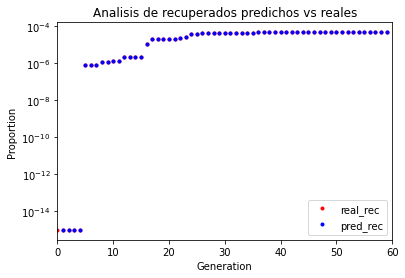

In [29]:
predicted_recov = res[:,2].detach().numpy()
real_recov = y[:,2].detach().numpy()
plt.plot(data.index, real_recov, color = 'r', linewidth=0, marker='.', label='real_rec')
plt.plot(data.index[1:], predicted_recov, color = 'b', linewidth=0, marker='.', label='pred_rec')
plt.yscale('log')
plt.xlim(0,len(y))
plt.ylabel('Proportion')
plt.xlabel('Generation')
plt.title('Analisis de recuperados predichos vs reales')
plt.legend()
plt.savefig(f'figures/{enfermedad}/accumul_prediction_rec.png', format='png', linewidth = 0.01)

Testeemos los parametros

In [30]:
params = list(model.parameters())
lambda1 = params[0].item()
lambda2 = params[1].item()
lambda3 = params[2].item()
print(params)

[Parameter containing:
tensor([[0.1835]], requires_grad=True), Parameter containing:
tensor([[0.0314]], requires_grad=True), Parameter containing:
tensor([[0.4685]], requires_grad=True)]


Recordemos que estamos modelando:

$$\dfrac{ds}{dt} = -\lambda_1 s i - \lambda_2 s  $$
\
$$\dfrac{di}{dt} = \lambda_1 s i - \lambda_3 i - \lambda_2 i  $$

\
$$\dfrac{dr}{dt} = \lambda_3 i  $$
\
$$\dfrac{dv}{dt} = \lambda_2 s + \lambda_2 i   $$



Entonces

$$\beta = \lambda_1 = R_0 / d $$

Con d la duración de la infeccion.

$$ \lambda_2 = \eta $$ la tasa de inmunización y

$$ \lambda_3 = \nu  = 1 / d $$

Primero veamos la tasa de immunizacion

In [31]:
tasa_immunizacion = (data.apply(lambda x: x.diff()).dropna().mean()/data['Vacunados'].max()).iloc[3]

In [32]:
tasa_immunizacion

0.003768821129237103

In [33]:
from IPython.display import Latex
Latex(f"""Deducimos que:
$$ \eta = \lambda_2 = {{{lambda2:.5f}}} \\approx {{{tasa_immunizacion:.5f}}} $$""")

<IPython.core.display.Latex object>

In [34]:
Latex(f"""Deducimos que:
$$ d = 1 / \lambda_3 = 1 / {{{lambda3:.2f}}} \\approx {{{1/lambda3:.2f}}} $$
$$ R_0 =  \lambda_1 * d = {{{lambda1:.2f}}} * d \\approx {{{lambda1/lambda3:.2f}}}$$""")

<IPython.core.display.Latex object>

Mientras que la literatura indica:

$$ d = 17.5 $$
$$ R_0 = 2.65 $$

## Validemos un test de momentos

#### Primer momento

In [35]:
import scipy

scipy.stats.ttest_ind(real_susceptible, predicted_susceptible, equal_var=False)

Ttest_indResult(statistic=-0.26842888126191555, pvalue=0.7888593603114055)

In [36]:
scipy.stats.ttest_ind(real_infected, predicted_infected, equal_var=False)

Ttest_indResult(statistic=-0.02417318239353432, pvalue=0.9807556747599588)

In [37]:
scipy.stats.ttest_ind(real_recov, predicted_recov, equal_var=False)

Ttest_indResult(statistic=-0.13485333609462244, pvalue=0.8929595562958634)

In [38]:
scipy.stats.ttest_ind(real_vaccinated, predicted_vaccinated, equal_var=False)

Ttest_indResult(statistic=0.2700480347117935, pvalue=0.787616676225677)

#### Segundo momento

In [39]:
scipy.stats.bartlett(real_infected, predicted_infected)

BartlettResult(statistic=0.0037152942488554485, pvalue=0.9513964698638504)

In [40]:
scipy.stats.bartlett(real_recov, predicted_recov)

BartlettResult(statistic=0.009536563744814217, pvalue=0.9222059863526999)

#### Test de bondad de ajuste de KS

In [41]:
scipy.stats.kstest(real_susceptible, predicted_susceptible, method='asymp')

KstestResult(statistic=0.18333333333333332, pvalue=0.23503052818957304)

In [42]:
scipy.stats.kstest(real_infected, predicted_infected, method='asymp')

KstestResult(statistic=0.3220338983050847, pvalue=0.0028709466816607687)

In [43]:
scipy.stats.kstest(real_recov, predicted_recov, method='asymp')

KstestResult(statistic=0.18333333333333335, pvalue=0.23503052818957304)

In [44]:
scipy.stats.kstest(real_vaccinated, predicted_vaccinated, method='asymp')

KstestResult(statistic=0.18333333333333335, pvalue=0.23503052818957304)

## Extrapolar

In [45]:
import sys
import os
sys.path.append('..')
import numpy as np
import pandas as pd
from models import sir
from config import get_project_root
import torchmetrics
from models.pytorchtools import EarlyStopping
import pathlib
import torch
import torch.nn as nn
import torch.nn.functional as F


In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

YEARS_TO_PREDICT = 5

model = torch.load(f'models/trained_models/{enfermedad}.pkl')
y = torch.from_numpy(data_numpy.astype(np.float32))
res = model(y, size_of_starter_set=40, amount_of_prediction_in_future=len(y)+12*YEARS_TO_PREDICT)

In [47]:
res[:,0].shape[0]

119

/var/folders/g0/jqvp4xxs5pn4cds1xb9339xm0000gn/T/ipykernel_5213/2038456406.py:14: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 1)
/var/folders/g0/jqvp4xxs5pn4cds1xb9339xm0000gn/T/ipykernel_5213/2038456406.py:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "linewidth" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'figures/{enfermedad}/extrapolation_{enfermedad}_log.png', format='png', linewidth = 0.01)


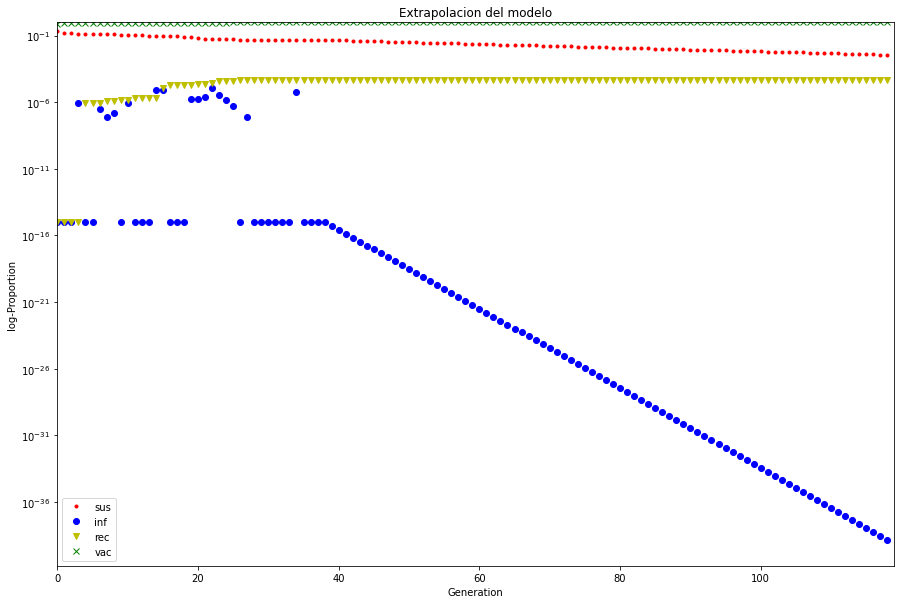

In [48]:
plt.figure(figsize=(15,10))
predicted_susceptible = res[:,0].detach().numpy()
predicted_infectous = res[:,1].detach().numpy()
predicted_recovered = res[:,2].detach().numpy()
predicted_vaccinated = res[:,3].detach().numpy()

plt.plot(range(res[:,0].shape[0]), predicted_susceptible, color = 'r', linewidth=0, marker='.', label='sus')
plt.plot(range(res[:,0].shape[0]), predicted_infectous, color = 'b', linewidth=0, marker='o', label='inf')
plt.plot(range(res[:,0].shape[0]), predicted_recovered, color = 'y', linewidth=0, marker='v', label='rec')
plt.plot(range(res[:,0].shape[0]), predicted_vaccinated, color = 'g', linewidth=0, marker='x', label='vac')

plt.yscale('log')

plt.ylim(0, 1)
plt.xlim(0,len(res[:,0]))
plt.ylabel('log-Proportion')
plt.xlabel('Generation')
plt.title('Extrapolacion del modelo')
plt.legend()
plt.savefig(f'figures/{enfermedad}/extrapolation_{enfermedad}_log.png', format='png', linewidth = 0.01)

/var/folders/g0/jqvp4xxs5pn4cds1xb9339xm0000gn/T/ipykernel_5213/1912378081.py:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "linewidth" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'figures/{enfermedad}/extrapolation_{enfermedad}_vac_suc.png', format='png', linewidth = 0.01)


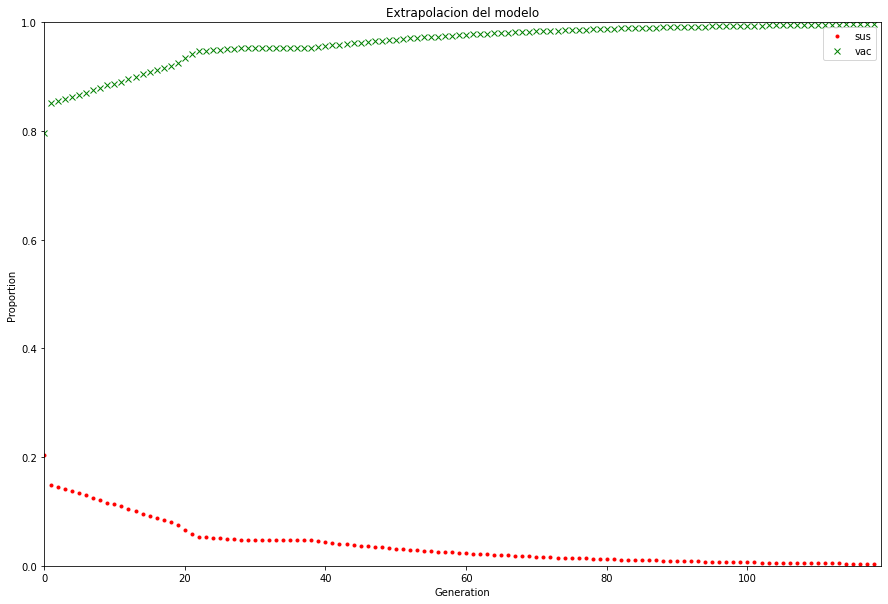

In [49]:
plt.figure(figsize=(15,10))
predicted_susceptible = res[:,0].detach().numpy()
# predicted_infectous = res[:,1].detach().numpy()
# predicted_recovered = res[:,2].detach().numpy()
predicted_vaccinated = res[:,3].detach().numpy()

plt.plot(range(res[:,0].shape[0]), predicted_susceptible, color = 'r', linewidth=0, marker='.', label='sus')
# plt.plot(range(res[:,0].shape[0]), predicted_infectous, color = 'b', linewidth=0, marker='o', label='inf')
# plt.plot(range(res[:,0].shape[0]), predicted_recovered, color = 'y', linewidth=0, marker='v', label='rec')
plt.plot(range(res[:,0].shape[0]), predicted_vaccinated, color = 'g', linewidth=0, marker='x', label='vac')

# plt.yscale('log')

plt.ylim(0, 1)
plt.xlim(0,len(res[:,0]))
plt.ylabel('Proportion')
plt.xlabel('Generation')
plt.title('Extrapolacion del modelo')
plt.legend()
plt.savefig(f'figures/{enfermedad}/extrapolation_{enfermedad}_vac_suc.png', format='png', linewidth = 0.01)

/var/folders/g0/jqvp4xxs5pn4cds1xb9339xm0000gn/T/ipykernel_5213/2545713931.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "linewidth" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'figures/{enfermedad}/extrapolation_{enfermedad}_inf_rec.png', format='png', linewidth = 0.01)


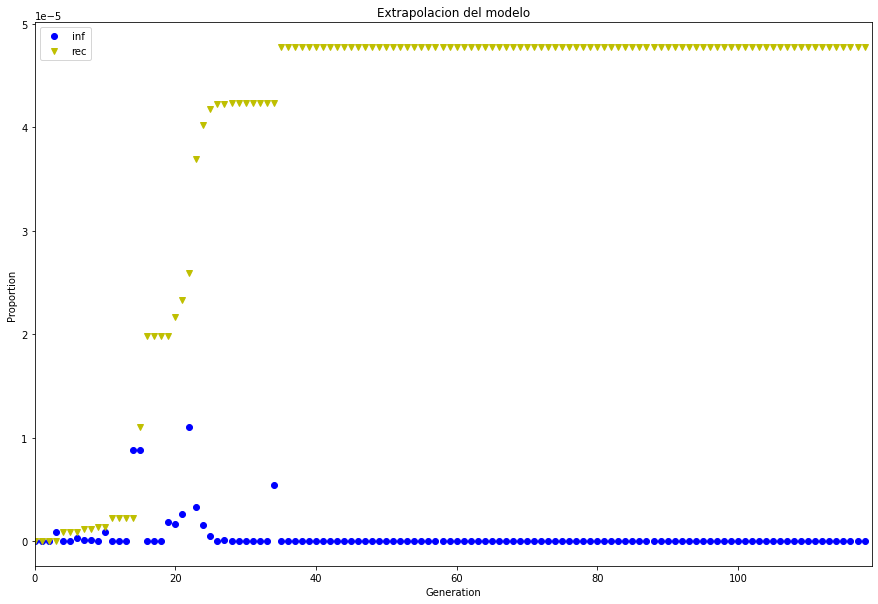

In [50]:
plt.figure(figsize=(15,10))
# predicted_susceptible = res[:,0].detach().numpy()
predicted_infectous = res[:,1].detach().numpy()
predicted_recovered = res[:,2].detach().numpy()
# predicted_vaccinated = res[:,3].detach().numpy()

# plt.plot(range(res[:,0].shape[0]), predicted_susceptible, color = 'r', linewidth=0, marker='.', label='sus')
plt.plot(range(res[:,0].shape[0]), predicted_infectous, color = 'b', linewidth=0, marker='o', label='inf')
plt.plot(range(res[:,0].shape[0]), predicted_recovered, color = 'y', linewidth=0, marker='v', label='rec')
# plt.plot(range(res[:,0].shape[0]), predicted_vaccinated, color = 'g', linewidth=0, marker='x', label='vac')

# plt.yscale('log')

plt.xlim(0,len(res[:,0]))
plt.ylabel('Proportion')
plt.xlabel('Generation')
plt.title('Extrapolacion del modelo')
plt.legend()
plt.savefig(f'figures/{enfermedad}/extrapolation_{enfermedad}_inf_rec.png', format='png', linewidth = 0.01)